# Flow-Shop Scheduling

In [1]:
import pandas as pd
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
import copy
import random
from random import shuffle, randrange, getrandbits
import itertools
from datetime import datetime
import os
from pathlib import Path
import time

## Loading Problem Instances

In [2]:
# Load the flow-shop problem using it's filepath
# Returns dataframe and problem header
def get_problem(filepath):
    with open(filepath) as f:
        firstline = f.readline().rstrip()
        header = firstline.split(" ")     
    data = pd.read_csv(filepath, sep= " ", header=None, skiprows=1)
    return data, header

# Turns dataframe into a schedule object to be used by the GA
# Pass an array of integers as 'schedule' to create a schedule object
# with a specific order of jobs.
def df_to_schedule(data, nums, solution = None):
    data = data.to_numpy()
    jobs = []
    for i,row in enumerate(data):
        jobs.append(Job(row, i+1))
        
    # Reorder jobs in certain order
    # Can be used for checking solutions
    if solution:
        temp = [0] * len(solution)
        for i, job_num in enumerate(solution):
            temp[i] = jobs[job_num-1]
        jobs = temp
        
    schedule = Schedule(jobs, int(nums[1]))
    return schedule
    
# Writing results to file
def write_results(data, hist, pop_size, mutation_rate, crossover_rate):
    if isinstance(data, str):
        filename = Path(data).stem
    else:
        filename = "object_input"
    now = datetime.now()
    dt = now.strftime("%d-%m_%H-%M-%S")
    write_name = f"{os.path.basename(filename)}_p{pop_size}_mr{int(mutation_rate*100)}_cr{int(crossover_rate*100)}_({dt}).csv"
    pd.DataFrame(hist).to_csv("experiments/" + write_name)
    

## GA Methods and Helpers

In [3]:
class GA():
    @staticmethod
    def op_cross(s1, s2):
        j1 = s1.jobs
        j2 = s2.jobs
        child = [0] * len(j1)
        
        # Selecting random index in parent one
        point = randrange(0, len(j1))
        
        LR = bool(getrandbits(1))
        # Going left or right from point to start child gene
        # Left from index
        if(LR):
            child[0:point+1] = j1[0:point+1]
            comp = child[0:point+1]
            empty = [x for x in range(point+1, len(j1))]
        # Right from index
        else:
            child[point:] = j1[point:]
            comp = child[point:]
            empty = [x for x in range(0, point+1)]
        
        index = 0
        # Getting remaining values from second parent, in order
        for i, job in enumerate(j2):
            if job not in comp:
                child[empty[index]] = job
                index += 1
                
        child_s = Schedule(child, s1.m)
            
        return child_s
    
    @staticmethod
    def tp_cross(s1, s2):
        j1 = s1.jobs
        j2 = s2.jobs
        child = [0] * len(j1)
        
        # Selecting two random indexes in parent one
        p1 = randrange(0, len(j1))
        p2 = randrange(0, len(j1))
        
        l = min(p1, p2)
        r = max(p1, p2)
        full = [x for x in range(l, r+1)]
        comp = j1[l:r+1]
        # Going left or right from point to start child gene
        # Left from index
        child[l:r+1] = j1[l:r+1]
                    
        empty_indices = [x for x in range(0, len(j1)) if x not in full]
        
        index = 0     
        for job in j2:
            if job not in comp:
                child[empty_indices[index]] = job
                index += 1
                
        child_s = Schedule(child, s1.m)
            
        return child_s
    
    @staticmethod
    def exchange_mutation(s, prob):
        if(random.random() > prob):
            return
    
        jobs = s.jobs
        
        p1 = randrange(0, len(jobs))
        p2 = randrange(0, len(jobs)) 
        
        jobs[p1], jobs[p2] = jobs[p2] , jobs[p1]
        
        s.jobs = (jobs)
        s.set_makespan()
        
    @staticmethod
    def shift_mutation(s, prob):
        if(random.random() > prob):
            return
    
        jobs = s.jobs
        
        p1 = randrange(0, len(jobs)) 
        p2 = randrange(0, len(jobs)) 
        job = jobs[p1]
        jobs.remove(job)
        jobs.insert(p2, job)
        
        
        s.jobs = (jobs)
        s.set_makespan()
        
    @staticmethod
    def roulette_selection(pop, n):
        total_inv = sum([1./s.makespan() for s in pop])

        selection_probs = [(1./s.makespan())/total_inv for s in pop]

        # Take out least fit individuals
        new_pop = np.random.choice(pop, size=n, replace=False, p=selection_probs)

        return new_pop.tolist()
    
    @staticmethod
    def take_n_best(pop, n):
        sorted_pop = sorted(pop, key=lambda x: x.makespan())
        return sorted_pop[:n]

    # Get index list of sorted fitness
    @staticmethod
    def fitness_indexes(pop):
        fitness_values = []
        for p in pop:
            fitness_values.append(p.makespan())
        return np.argsort(fitness_values)

### Objects Used for GA

In [4]:
class Schedule():
    def __init__(self, jobs, num_machines):
        self.jobs = jobs
        
        self.m = num_machines
        self.makespan_matrix = None
        self.set_makespan()
        
        

    # Calculates makespan using NxM matrix
    def set_makespan(self):
        # Num machines x Num Jobs
        end_times = np.zeros((self.m, len(self.jobs)))

        end_times[0][0] = self.jobs[0].tasks[0].length
        for i in range(1, len(self.jobs)):
            end_times[0][i] = end_times[0][i-1] + self.jobs[i].tasks[0].length

        for x in range(1, self.m):
            for y, job in enumerate(self.jobs):
                if (y ==0):
                    end_times[x][y] = end_times[x-1][y] + job.tasks[x].length
                else:
                    prereq_end = end_times[x-1][y]

                    prev_task_end = end_times[x][y-1]

                    end_times[x][y] = max(prereq_end, prev_task_end) + job.tasks[x].length

        self.makespan_matrix = end_times
            
    def makespan(self):
        return int(self.makespan_matrix[-1][-1])
                
    def reorder(self, order):
        temp = [0] * len(order)
        for i, job_num in enumerate(order):
            temp[i] = self.jobs[job_num-1]
        self.jobs = temp
        self.set_makespan()
            
    def randomize(self):
        shuffle(self.jobs)
        self.set_makespan()
        return self
    
    def random_copy(self):
        s = Schedule(self.jobs, self.m)
        s = s.randomize()
        return s

    def print_times(self):
        for machine in self.machines:
            track_schedule = ""
            for task in machine:
                track_schedule += f"{task.start} - {task.end} |"
            print(track_schedule)
            
    def get_df(self):
        df = {"job" : [], "task": [],  "start": [], "end": [], "machine": [], "original_id" : []}
        count = 1
        for task_id, row in enumerate(self.makespan_matrix):
            for job_id, end_time in enumerate(row):
                df["job"].append(job_id+1)
                df["task"].append(task_id+1)
                df["start"].append(end_time - self.jobs[job_id].tasks[task_id].length)
                df["end"].append(end_time)
                df["machine"].append(f"Machine {task_id+1}")
                df["original_id"].append(self.jobs[job_id].ID)
                count += 1
        return pd.DataFrame(data=df)

    
    def __repr__(self):
        rep = "|"
        for job in self.jobs:
            rep += str(job) + " "
        return rep + "|"
    
    # Shows gantt chart for current job schedule
    def gantt_chart(self):
        df = self.get_df()
        df['width'] = (df.end-df.start)
        fig, ax = plt.subplots(1, figsize=(16,6))
        df = df.reset_index()  # make sure indexes pair with number of rows
        for job_num in range(1, len(self.jobs)+1):
            row = df.loc[df['original_id'] == job_num]
            ax.barh(row['machine'], row['width'], left=row['start'], edgecolor='white', label=f"Job {job_num}")
            
        # Y axis Labels
        y_labels = []
        for i in range(1, self.m+1):
            y_labels.append(f"Machine {i}")
        ax.set_yticks(y_labels)
        ax.invert_yaxis()
        
        ax.set_title(f"Flow Shop Visualization ({len(self.jobs)} Jobs, {self.m} Machines)")
        ax.set_xlabel("Time Units")
        
        if(len(self.jobs) <= 10):
            plt.legend(title=f'Makespan: {round(self.makespan_matrix[-1][-1])}')
        else:
            plt.legend([], title=f'Makespan: {round(self.makespan_matrix[-1][-1])}' )
        plt.show()
        print(self.makespan())
                    

    def __eq__(self, other):
        return str(self) == str(other)
    
    def __hash__(self):
        return hash(str(self))

class Job():
    def __init__(self, length_per_task, job_id=-1):
        self.n = len(length_per_task)
        self.tasks = []
        self.start = 0
        self.end = 0
        self.ID = job_id
        #Linked list of task hierarchy
        for i, length in enumerate(length_per_task):
            self.tasks.append(Task(None, length, (job_id, i)))
        for i in range(1, len(self.tasks)):
            self.tasks[i].parent = self.tasks[i-1]
            
    def __hash__(self):
        return self.ID
    
    def __eq__(self, other):
        return self.ID == other.ID
    
    def __str__(self):
        return str(self.ID)
    
    def __repr__(self):
        return str(self.ID)

class Task():
    def __init__(self, parent, length, ID = None):
        self.parent = parent # Task that preceedes this
        self.length = length # How long task will take
        self.ID = ID
        
    def __str__(self):
        return str(self.ID)
    
    def set_start(self, start):
        self.start = start
        self.end = start + self.length

## GA Implementation

In [5]:
def flow_shop_GA(data, generations, pop_size, mutation_rate, crossover_rate, crossover, mutation, save=False):
    '''Genetic Algorithm for the Flow Shop Problem
        data: Filepath for dataset instance or array of jobs
        generations: number of iterations
        pop_size: number of individiuals in each iteration
        mutation_rate: chance of mutation in individuals
        crossover_rate: percentage of invidiuals created from crossover in each generation
        crossover: function for crossovers
        mutation: function for mutation
        save: saving some results to file
        
        Returns:
        best_individual: Individual with lowest overall makespan
        ms_hist: average makespan at each generation
        best_sol_hist: lowest makespan at each generation
        time_elapsed: time that the algorirthm took to complete
        
    '''
    # Random seed for reproducable results
    random.seed(42)
    np.random.seed(42)
    
    # Start timer
    start = time.time()
    
    # Average makespan history
    ms_hist = []
    
    #Best solution in each generation
    best_sol_hist = []
    
    # Unique solutions in each generation
    diversity = []
    
    # Schedules from input file
    if isinstance(data, str):
        df, nums = get_problem(data)
        initial_pop = [df_to_schedule(df, nums) for x in range(pop_size)]
        
    # Schedules from array of jobs
    else:
        initial_pop = [Schedule(data, data[0].n) for x in range(pop_size)]
    
    #Shuffle schedules
    for s in initial_pop:
        shuffle(s.jobs)
        
    current_pop = initial_pop
    scores = [s.makespan() for s in current_pop]
    
    # Get stats
    best_individual = current_pop[np.argmin(scores)]
    ms_hist.append(sum(scores)/pop_size)
    unique = len(set(current_pop))
    diversity.append(unique)
    
    for gen in range(1, generations+1):
        new_pop = []
        num_clones = pop_size - round((pop_size * crossover_rate))
        num_children = pop_size - num_clones
    
        
        surviving = GA.roulette_selection(current_pop, num_clones)
        
        # Perform crossovers
        for i in range(num_children):
            parents = GA.roulette_selection(current_pop, 2)
            child = crossover(parents[0], parents[1])
            new_pop.append(child)
            
        new_pop = new_pop + surviving
        
        # Mutate schedules
        for schedule in new_pop:
            mutation(schedule, mutation_rate)
            
        current_pop = new_pop
        if(gen % 10 == 0):
            print(f"Iteration: {gen} Current_pop: {len(current_pop)} average_makespan: {sum([s.makespan() for s in current_pop])/pop_size}")
        
        scores = [s.makespan() for s in current_pop]
        best_in_pop = current_pop[np.argmin(scores)]
        best_sol_hist.append(best_individual.makespan())
        
        # Check for new best solution
        if (best_in_pop.makespan() < best_individual.makespan()):
            print(f"New best: {best_in_pop.makespan()}")
            best_individual = best_in_pop
        
        ms_hist.append(sum(scores)/pop_size)
        unique = len(set(current_pop))
        diversity.append(unique)
     
    if save:
        write_results(data, ms_hist, pop_size, mutation_rate, crossover_rate)
        
    end = time.time()
    time_elapsed = end- start
    return [best_individual, ms_hist, best_sol_hist, time_elapsed]

## Example Run

In [9]:
best, ms_hist, sol_hist, algo_time = flow_shop_GA("dataset/ta001.txt", 500, 100, 0.1, 0.8, GA.op_cross, GA.exchange_mutation, save=False)

New best: 1399
New best: 1387
New best: 1360
New best: 1348
New best: 1344
Iteration: 10 Current_pop: 100 average_makespan: 1503.87
New best: 1344
Iteration: 20 Current_pop: 100 average_makespan: 1498.26
Iteration: 30 Current_pop: 100 average_makespan: 1501.23
Iteration: 40 Current_pop: 100 average_makespan: 1498.7
Iteration: 50 Current_pop: 100 average_makespan: 1483.73
Iteration: 60 Current_pop: 100 average_makespan: 1481.84
Iteration: 70 Current_pop: 100 average_makespan: 1469.23
Iteration: 80 Current_pop: 100 average_makespan: 1474.15
Iteration: 90 Current_pop: 100 average_makespan: 1473.84
Iteration: 100 Current_pop: 100 average_makespan: 1480.4
Iteration: 110 Current_pop: 100 average_makespan: 1476.5
Iteration: 120 Current_pop: 100 average_makespan: 1464.3
Iteration: 130 Current_pop: 100 average_makespan: 1507.52
Iteration: 140 Current_pop: 100 average_makespan: 1503.08
Iteration: 150 Current_pop: 100 average_makespan: 1498.87
Iteration: 160 Current_pop: 100 average_makespan: 149

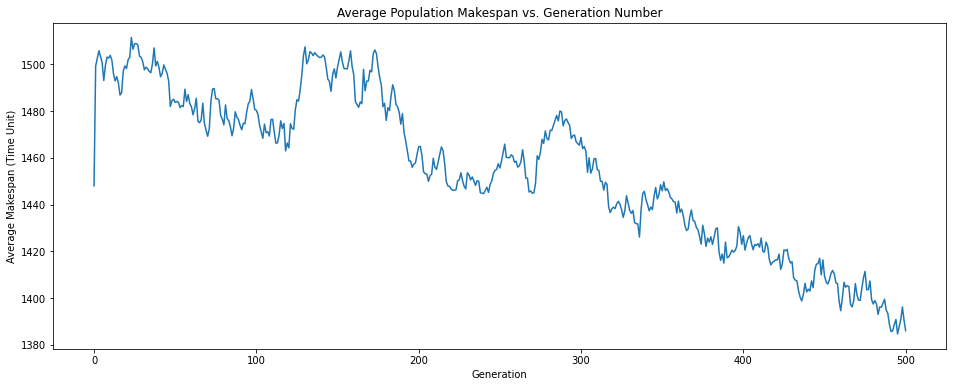

In [10]:
fig, ax = plt.subplots(1, figsize=(16,6))
ax.plot(ms_hist)
ax.set_title("Average Population Makespan vs. Generation Number")
ax.set_xlabel(f"Generation")
ax.set_ylabel("Average Makespan (Time Unit)")
plt.show()

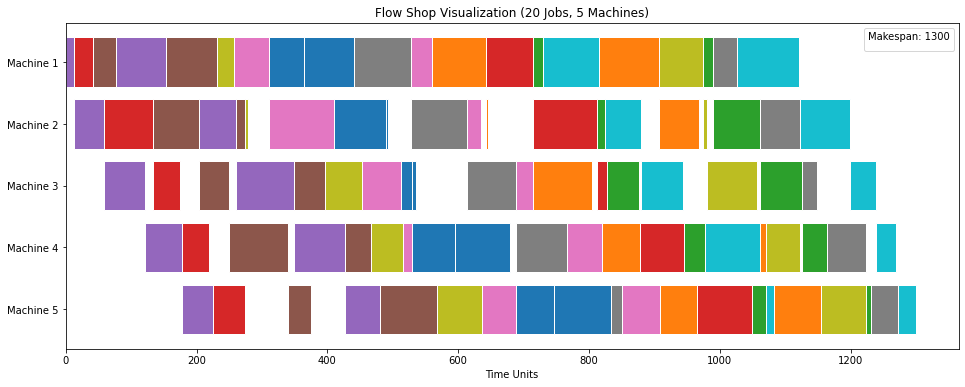

1300


In [11]:
best.gantt_chart()

## Reproducing Report Results
There may be some variation in results from the report as seeded number generation was not used for all experiements.

In [ ]:
op_01 = flow_shop_GA("dataset/ta001.txt", 1000, 100, 0.1, 0.8, GA.op_cross, GA.exchange_mutation, save=True)
tp_01 = flow_shop_GA("dataset/ta001.txt", 1000, 100, 0.1, 0.8, GA.tp_cross, GA.shift_mutation, save=True)

op_31 = flow_shop_GA("dataset/ta031.txt", 1000, 100, 0.1, 0.8, GA.op_cross, GA.exchange_mutation, save=True)
tp_31 = flow_shop_GA("dataset/ta031.txt", 1000, 100, 0.1, 0.8, GA.tp_cross, GA.shift_mutation, save=True)

op_61 = flow_shop_GA("dataset/ta061.txt", 1000, 100, 0.1, 0.8, GA.op_cross, GA.exchange_mutation, save=True)
tp_61 = flow_shop_GA("dataset/ta061.txt", 1000, 100, 0.1, 0.8, GA.tp_cross, GA.shift_mutation, save=True)

op_71 = flow_shop_GA("dataset/ta071.txt", 1000, 100, 0.1, 0.8, GA.op_cross, GA.exchange_mutation, save=True)
tp_71 = flow_shop_GA("dataset/ta071.txt", 1000, 100, 0.1, 0.8, GA.tp_cross, GA.shift_mutation, save=True)

op_91 = flow_shop_GA("dataset/ta091.txt", 1000, 100, 0.1, 0.8, GA.op_cross, GA.exchange_mutation, save=True)
tp_91 = runflow_shop_GA("dataset/ta091.txt", 1000, 100, 0.1, 0.8, GA.tp_cross, GA.shift_mutation, save=True)

op_101 = flow_shop_GA("dataset/ta101.txt", 1000, 100, 0.1, 0.8, GA.op_cross, GA.exchange_mutation, save=True)
tp_101 = run("dataset/ta101.txt", 1000, 100, 0.1, 0.8, GA.tp_cross, GA.shift_mutation, save=True)

op_111 = flow_shop_GA("dataset/ta111.txt", 1000, 100, 0.1, 0.8, GA.op_cross, GA.exchange_mutation, save=True)
tp_111 = flow_shop_GA("dataset/ta111.txt", 1000, 100, 0.1, 0.8, GA.tp_cross, GA.shift_mutation, save=True)